In [1]:
import time
t_start1 = time.perf_counter()


%matplotlib inline

# Importing Libraries
import sys
import numbers
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from functools import reduce

import pmdarima as pmd
import statsmodels.api as sm 
from scipy.stats import normaltest

from darts import TimeSeries
from darts.models import NBEATSModel
from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox


from darts.datasets import AirPassengersDataset, AusBeerDataset, GasRateCO2Dataset 
from darts.datasets import HeartRateDataset, IceCreamHeaterDataset, MonthlyMilkDataset
from darts.datasets import SunspotsDataset


import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

2022-05-29 21:54:54 prophet.plot ERROR: Importing plotly failed. Interactive plots will not work.
/Users/s1b0ert/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/s1b0ert/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/s1b0ert/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64

In [16]:
TRAIN = dt.datetime(1958,1,1).date()

component   #Passengers
Month                  
1949-01-01        112.0
1949-02-01        118.0
1949-03-01        132.0
1949-04-01        129.0
1949-05-01        121.0
...                 ...
1960-08-01        606.0
1960-09-01        508.0
1960-10-01        461.0
1960-11-01        390.0
1960-12-01        432.0

[144 rows x 1 columns]
component   #Passengers
Month                  
1949-01-01        112.0
1949-02-01        118.0
1949-03-01        132.0
1949-04-01        129.0
1949-05-01        121.0
...                 ...
1957-08-01        467.0
1957-09-01        404.0
1957-10-01        347.0
1957-11-01        305.0
1957-12-01        336.0

[108 rows x 1 columns]
component   #Passengers
Month                  
1958-01-01        340.0
1958-02-01        318.0
1958-03-01        362.0
1958-04-01        348.0
1958-05-01        363.0
1958-06-01        435.0
1958-07-01        491.0
1958-08-01        505.0
1958-09-01        404.0
1958-10-01        359.0
1958-11-01        310.0
1958-12-01      

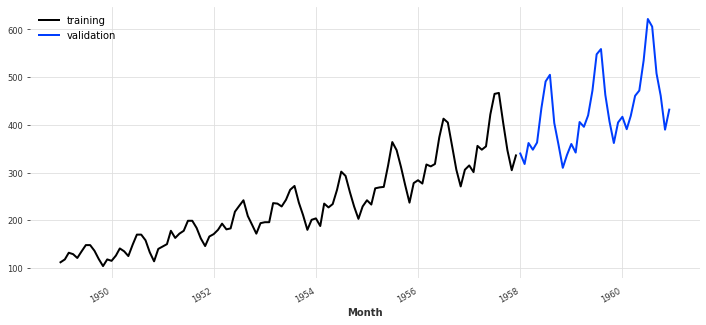

In [17]:
series = AirPassengersDataset().load()
series_df = series.pd_dataframe()
print(series_df)

## split train and test data

# split position: if string, then interpret as Timestamp
# if int, then interpretation as index
# if loat, then interpretation as %split
if isinstance(TRAIN, numbers.Number):
    split_at = TRAIN
else:
    split_at = pd.Timestamp(TRAIN)
train, val = series.split_before(split_at)

train_df = train.pd_dataframe()
print(train_df)

val_df = val.pd_dataframe()
print(val_df)

plt.figure(101, figsize=(12, 5))
train.plot(label='training')
val.plot(label='validation')
plt.legend();

component   #Passengers
Month                  
1949-01-01     0.022039
1949-02-01     0.038567
1949-03-01     0.077135
1949-04-01     0.068871
1949-05-01     0.046832
...                 ...
1957-08-01     1.000000
1957-09-01     0.826446
1957-10-01     0.669421
1957-11-01     0.553719
1957-12-01     0.639118

[108 rows x 1 columns]


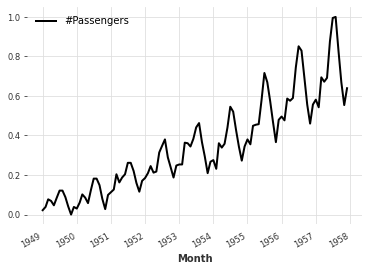

In [18]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
train_scaled = scaler.fit_transform(train)

train_scaled.plot()
print(train_scaled.pd_dataframe())

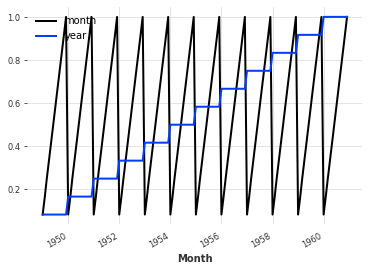

In [19]:
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

air_covs = concatenate(
    [
        dt_attr(series.time_index, "month", dtype=np.float32) / 12,
        (dt_attr(series.time_index, "year", dtype=np.float32) - 1948) / 12,
    ],
    axis="component",
)
air_covs.plot()

In [20]:
train_covs, val_covs = air_covs.split_before(split_at)
print(len(train_covs))
print(len(val_covs))

print(train_covs.pd_dataframe())
print(val_covs.pd_dataframe())

108
36
component      month      year
Month                         
1949-01-01  0.083333  0.083333
1949-02-01  0.166667  0.083333
1949-03-01  0.250000  0.083333
1949-04-01  0.333333  0.083333
1949-05-01  0.416667  0.083333
...              ...       ...
1957-08-01  0.666667  0.750000
1957-09-01  0.750000  0.750000
1957-10-01  0.833333  0.750000
1957-11-01  0.916667  0.750000
1957-12-01  1.000000  0.750000

[108 rows x 2 columns]
component      month      year
Month                         
1958-01-01  0.083333  0.833333
1958-02-01  0.166667  0.833333
1958-03-01  0.250000  0.833333
1958-04-01  0.333333  0.833333
1958-05-01  0.416667  0.833333
1958-06-01  0.500000  0.833333
1958-07-01  0.583333  0.833333
1958-08-01  0.666667  0.833333
1958-09-01  0.750000  0.833333
1958-10-01  0.833333  0.833333
1958-11-01  0.916667  0.833333
1958-12-01  1.000000  0.833333
1959-01-01  0.083333  0.916667
1959-02-01  0.166667  0.916667
1959-03-01  0.250000  0.916667
1959-04-01  0.333333  0.916667
1959-05-

In [31]:
model = NBEATSModel(input_chunk_length=48, output_chunk_length=36, random_state=42)

model.fit(train_scaled,
          past_covariates=train_covs,
          epochs=100,
          verbose=True,
         )

Training: 0it [00:00, ?it/s]

Predicting: 1it [00:00, ?it/s]

12.233432317953628


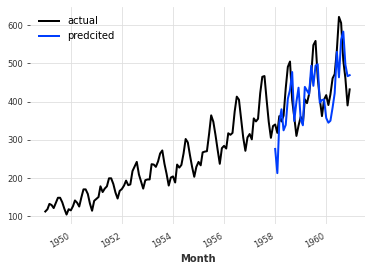

In [33]:
forecast = model.predict(series=train_scaled, past_covariates=train_covs, n=36)
forecast = scaler.inverse_transform(forecast)

series.plot(label='actual')
forecast.plot(label='predcited')

print(mape(val, forecast))

In [34]:
model = NBEATSModel(input_chunk_length=48, output_chunk_length=12, random_state=42)

model.fit(train_scaled,
          past_covariates=train_covs,
          epochs=50,
          verbose=True,
         )

Training: 0it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

6.998906984503613


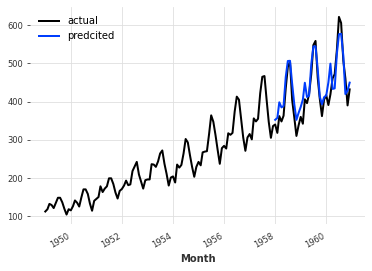

In [35]:
forecast = model.predict(series=train_scaled, past_covariates=air_covs, n=36)
forecast = scaler.inverse_transform(forecast)

series.plot(label='actual')
forecast.plot(label='predcited')
print(mape(val, forecast))